In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [2]:
# import the first dataset for the autoencoder

DATADIR = 'C:/Users/epoli/PycharmProjects/Real and AI-generated faces/dataset1'

# specify image size
IMG_SIZE = 128


In [3]:
# import images from file with "DATADIR" path 

training_data = []

def create_training_data():

    path = os.path.join(DATADIR)
    for img in tqdm(os.listdir(path)):  
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            training_data.append([new_array])  # add to our training_data
        except Exception as e:  # to keep the output clean
            pass                        

In [4]:
create_training_data()

# place the images into training data array 
training_data = np.array(training_data)
print(training_data.shape)

# we use np.squeeze to drop the second dimension we don't use
training_data = np.squeeze(training_data, axis=(1,))
print(training_data.shape)

100%|██████████| 10000/10000 [00:15<00:00, 637.64it/s]


(10000, 1, 128, 128, 3)
(10000, 128, 128, 3)


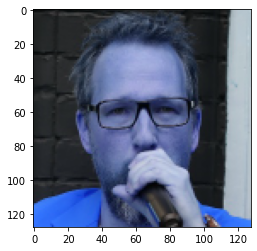

[[[ 10  12  12]
  [  7   9   9]
  [  9  11  11]
  ...
  [182 197 206]
  [181 198 207]
  [184 201 210]]

 [[ 18  20  20]
  [ 15  17  17]
  [ 17  19  19]
  ...
  [182 197 206]
  [179 196 205]
  [186 203 212]]

 [[ 39  41  41]
  [ 39  41  41]
  [ 38  40  40]
  ...
  [182 197 206]
  [178 195 204]
  [178 195 204]]

 ...

 [[ 54 116 255]
  [ 53 115 255]
  [ 51 116 255]
  ...
  [ 57 126 255]
  [ 60 127 253]
  [ 64 128 251]]

 [[ 54 116 255]
  [ 53 115 255]
  [ 49 114 253]
  ...
  [ 53 124 255]
  [ 55 125 255]
  [ 57 126 253]]

 [[ 53 115 255]
  [ 52 114 254]
  [ 49 113 251]
  ...
  [ 54 122 254]
  [ 56 124 254]
  [ 59 125 253]]]


In [5]:
# our images look like this with size 128x128:
plt.imshow(training_data[0])
plt.show()
print(training_data[0])

In [6]:
# normalize values of image arrays between 0 and 1
training_data = training_data/255.0
training_data[0]

array([[[0.03921569, 0.04705882, 0.04705882],
        [0.02745098, 0.03529412, 0.03529412],
        [0.03529412, 0.04313725, 0.04313725],
        ...,
        [0.71372549, 0.77254902, 0.80784314],
        [0.70980392, 0.77647059, 0.81176471],
        [0.72156863, 0.78823529, 0.82352941]],

       [[0.07058824, 0.07843137, 0.07843137],
        [0.05882353, 0.06666667, 0.06666667],
        [0.06666667, 0.0745098 , 0.0745098 ],
        ...,
        [0.71372549, 0.77254902, 0.80784314],
        [0.70196078, 0.76862745, 0.80392157],
        [0.72941176, 0.79607843, 0.83137255]],

       [[0.15294118, 0.16078431, 0.16078431],
        [0.15294118, 0.16078431, 0.16078431],
        [0.14901961, 0.15686275, 0.15686275],
        ...,
        [0.71372549, 0.77254902, 0.80784314],
        [0.69803922, 0.76470588, 0.8       ],
        [0.69803922, 0.76470588, 0.8       ]],

       ...,

       [[0.21176471, 0.45490196, 1.        ],
        [0.20784314, 0.45098039, 1.        ],
        [0.2       , 0

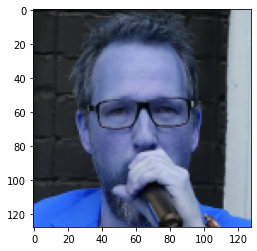

In [7]:
plt.imshow(training_data[0])

In [26]:
# now that we have our training_data ready let's create the auto encoder


opt = tf.keras.optimizers.RMSprop(learning_rate=0.0005, epsilon=1e-6)
img_in = keras.Input(shape=(128, 128, 3), name='img_in')


def encoder(img_in):

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(img_in)  # 128x128x128
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                         # 64x64x128
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)       
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                         # 32x32x128
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)        # 32x32x64
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)                         # 16x16x64                         
    #x = keras.layers.Flatten()(x)
    #encoder_output = keras.layers.Dense(1024, activation='relu')(x)

    return x


def decoder(encoder_output):
    #encoder_output = keras.layers.Dense(512, activation='relu')(encoder_output)
    decoder_input = keras.layers.Flatten()(encoder_output)
    decoder_input = keras.layers.Dense(32, activation='relu')(encoder_output)      
    x = keras.layers.Reshape((16, 16, 32))(decoder_input)                            # 16x16x32
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)        # 16x16x64
    x = keras.layers.UpSampling2D((2, 2))(x)                                         # 32x32x64
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)       # 32x32x128
    x = keras.layers.UpSampling2D((2, 2))(x)                                         # 64x64x128
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)       
    x = keras.layers.UpSampling2D((2, 2))(x)                                    # 128x128x128(back to original input)
    decoder_output = keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

    return decoder_output


In [27]:

autoencoder = keras.Model(img_in, decoder(encoder(img_in)))
autoencoder.compile(opt, loss='mse', metrics=['acc'])

autoencoder.summary()

trained_ae = autoencoder.fit(training_data,
                             training_data,
                             epochs=50,
                             batch_size=32,
                             validation_split=0.2)



autoencoder.save_weights('autoencoder.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 128)       0     

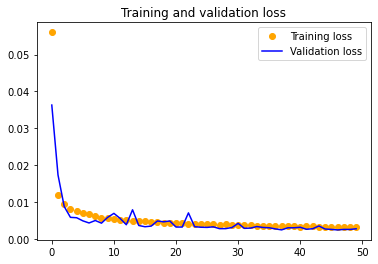

In [28]:
loss = trained_ae.history['loss']
val_loss = trained_ae.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', color='orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


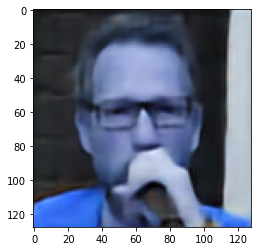

In [29]:
# the result image passed through the autoencoder
ae = autoencoder.predict([training_data[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3)])
plt.imshow(ae[0])
plt.show()



In [30]:
# Now lets get and prepare the images of second dataset for the classification
DATADIR = "C:/Users/epoli/PycharmProjects/Real and AI-generated faces/dataset2"
# we have two categories
CATEGORIES = ["Fake", "Real"]
IMG_SIZE = 128

In [31]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # for fakes and reals
        path = os.path.join(DATADIR, category)  # create path fakes and reals
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=fake 1=real

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  
                pass


create_training_data()

print(len(training_data))

import random

random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

y = np.array(y)
X = np.array(X)
X = X/255.0

100%|██████████| 10000/10000 [00:17<00:00, 555.75it/s]


20000
0
1
0
0
1
1
1
0
1
0


(128, 128, 3)
Real


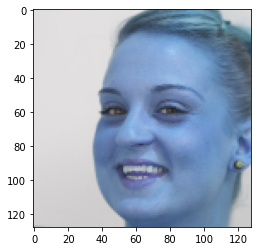

In [32]:
print(X[6].shape)
print(CATEGORIES[y[6]])

plt.imshow(X[6])
plt.show()

In [33]:
# let's split our data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.1)

In [34]:
# lets define our dense Layers for the classification

def classifier(enco):
    enco = keras.layers.Flatten()(enco)
    den = tf.keras.layers.Dense(256, activation='relu')(enco)
    out = tf.keras.layers.Dropout(0.8)(den)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(den)
    return out

encode = encoder(img_in)
full_model = keras.Model(img_in, classifier(encode))

# getting the wights from the encoder of the pretrained model and join them with our Fully Connected model

for i,j in zip(full_model.layers[:10],autoencoder.layers[0:10]):
    i.set_weights(j.get_weights())


In [35]:
autoencoder.get_weights()[0][1]

array([[[ 0.07654752,  0.02582318,  0.03070294, ...,  0.12822181,
         -0.06202096, -0.04069867],
        [ 0.02535339, -0.02623184, -0.05042145, ...,  0.1097661 ,
         -0.02687926, -0.05410628],
        [ 0.08678941, -0.06194631, -0.04932511, ...,  0.03806406,
          0.03259757,  0.01633319]],

       [[-0.05441008,  0.00935454,  0.05371111, ...,  0.14169665,
         -0.09234201,  0.05197178],
        [-0.08859462, -0.00560631,  0.0264219 , ...,  0.03070712,
         -0.05591078,  0.07437433],
        [-0.05431746, -0.04300231, -0.08056413, ...,  0.08308662,
          0.01999436,  0.15442874]],

       [[-0.05021806,  0.02197021, -0.00291421, ...,  0.11457607,
         -0.09727561,  0.04073491],
        [-0.07481421, -0.06944353,  0.05457506, ...,  0.04567935,
         -0.09224341, -0.00430163],
        [-0.0634528 , -0.0232486 ,  0.10044245, ...,  0.00972757,
         -0.07767555,  0.12647483]]], dtype=float32)

In [36]:
full_model.get_weights()[0][1]

array([[[ 0.07654752,  0.02582318,  0.03070294, ...,  0.12822181,
         -0.06202096, -0.04069867],
        [ 0.02535339, -0.02623184, -0.05042145, ...,  0.1097661 ,
         -0.02687926, -0.05410628],
        [ 0.08678941, -0.06194631, -0.04932511, ...,  0.03806406,
          0.03259757,  0.01633319]],

       [[-0.05441008,  0.00935454,  0.05371111, ...,  0.14169665,
         -0.09234201,  0.05197178],
        [-0.08859462, -0.00560631,  0.0264219 , ...,  0.03070712,
         -0.05591078,  0.07437433],
        [-0.05431746, -0.04300231, -0.08056413, ...,  0.08308662,
          0.01999436,  0.15442874]],

       [[-0.05021806,  0.02197021, -0.00291421, ...,  0.11457607,
         -0.09727561,  0.04073491],
        [-0.07481421, -0.06944353,  0.05457506, ...,  0.04567935,
         -0.09224341, -0.00430163],
        [-0.0634528 , -0.0232486 ,  0.10044245, ...,  0.00972757,
         -0.07767555,  0.12647483]]], dtype=float32)

In [37]:
for layer in full_model.layers[0:12]:
    layer.trainable = False

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005, epsilon=1e-6)
full_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [39]:
y_test[2]

0

In [40]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_28 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 128)       0   

In [41]:
classification = full_model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=50,
                               validation_split=0.1)

Epoch 1/50
507/507 [==============================] - 16s 25ms/step - loss: 0.7252 - acc: 0.5451 - val_loss: 0.6713 - val_acc: 0.5961
Epoch 2/50
507/507 [==============================] - 11s 21ms/step - loss: 0.6559 - acc: 0.6123 - val_loss: 0.6424 - val_acc: 0.6228
Epoch 3/50
507/507 [==============================] - 11s 22ms/step - loss: 0.6332 - acc: 0.6402 - val_loss: 0.6303 - val_acc: 0.6417
Epoch 4/50
507/507 [==============================] - 11s 22ms/step - loss: 0.6208 - acc: 0.6554 - val_loss: 0.6234 - val_acc: 0.6500
Epoch 5/50
507/507 [==============================] - 12s 23ms/step - loss: 0.6121 - acc: 0.6605 - val_loss: 0.6203 - val_acc: 0.6594
Epoch 6/50
507/507 [==============================] - 12s 23ms/step - loss: 0.6062 - acc: 0.6717 - val_loss: 0.6174 - val_acc: 0.6622
Epoch 7/50
507/507 [==============================] - 12s 23ms/step - loss: 0.6029 - acc: 0.6731 - val_loss: 0.6116 - val_acc: 0.6617
Epoch 8/50
507/507 [==============================] - 12s 23ms

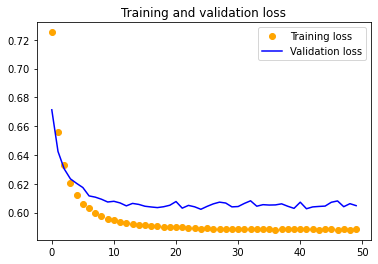

In [42]:
loss = classification.history['loss']
val_loss = classification.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', color='orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

[[0.90680635]]
Fake


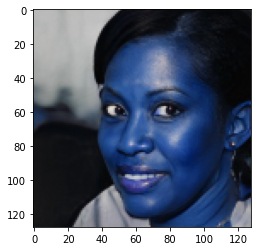

In [43]:
# the result image passed through the autoencoder
prediction = full_model.predict([X_test[3].reshape(-1, IMG_SIZE, IMG_SIZE, 3)])

print(prediction)
print(CATEGORIES[y_test[3]])
plt.imshow(X_test[3])
plt.show()

Found 1011 correct labels


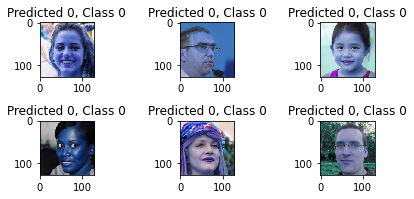

In [44]:
predicted_classes = full_model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
correct = np.where(predicted_classes==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:6]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()


Found 989 incorrect labels


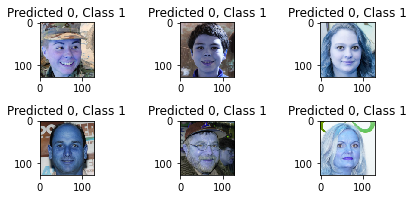

In [45]:
incorrect = np.where(predicted_classes!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [2]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test, predicted_classes, target_names=target_names))